In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
sh3_dataset = pd.read_csv('SH3_Full_Dataset_8_9_22.csv')

In [3]:
class ProteinDataset(torch.utils.data.Dataset):
    """
    A class to convert sequence data into numbers
    """
    def __init__(
        self,
        seqs
    ):
        self.seqs = seqs
        self.AMINO_ACIDS = "ARNDCQEGHILKMFPSTWYV-"
        self.IDX_TO_AA = list(self.AMINO_ACIDS)
        self.AA_TO_IDX = {aa : i for i, aa in enumerate(self.IDX_TO_AA)}

    def __len__(self):
        return len(self.seqs)
        
    def __getitem__(self, index):
        X = dict()
        Y = dict()

        X['seq'] = self.one_hot_encode(self.seqs[index])
        Y['seq'] = self.one_hot_encode(self.seqs[index])
        return X, Y

    def one_hot_encode(
        self,
        seq
    ):
        """
        generate one hot encoded sequences
        """
        seq_vector = torch.zeros((len(seq), len(self.IDX_TO_AA)), dtype=torch.float32)
        
        for index, char in enumerate(seq):
            seq_vector[index, self.AA_TO_IDX[char]] = 1.

        return seq_vector

In [4]:
seqs = np.asarray([ list(seq) for seq in sh3_dataset[sh3_dataset['Type'] == 'Naturals']['Sequences']])
dataset = ProteinDataset(seqs)

In [5]:
seqs[0]

array(['V', 'F', 'L', 'G', 'V', 'Y', 'K', 'A', 'L', 'Y', 'D', 'Y', 'E',
       'P', 'Q', 'T', 'T', 'E', 'E', 'L', 'A', 'I', 'R', 'E', 'D', 'E',
       'L', 'L', 'Y', 'L', 'L', 'E', 'K', 'S', 'D', 'E', 'W', 'W', 'T',
       'V', 'K', 'K', 'D', 'E', 'P', 'V', 'G', 'L', 'V', 'P', 'S', 'N',
       'Y', 'V', 'E', 'Q', 'A', 'P', 'V'], dtype='<U1')

In [6]:
dataset[0]

({'seq': tensor([[0., 0., 0.,  ..., 0., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 1., 0.]])},
 {'seq': tensor([[0., 0., 0.,  ..., 0., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 1., 0.]])})

In [172]:
class Encoder(torch.nn.Module):
    def __init__(
        self
    ):
        super().__init__()
        self.linear_1 = torch.nn.Linear(59*21, 200)
        self.activation_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(200, 200)
        self.activation_2 = torch.nn.ReLU()
        self.linear_3_z_mu = torch.nn.Linear(200, 3)
        self.linear_3_log_var = torch.nn.Linear(200, 3)

    def forward(
        self, 
        X
    ):
        h1 = self.linear_1(X)
        h1 = self.activation_1(h1)
        h2 = self.linear_2(h1)
        h2 = self.activation_2(h2)
        z_mu = self.linear_3_z_mu(h2)
        log_var = self.linear_3_log_var(h2)

        return z_mu, log_var


class Decoder(torch.nn.Module):
    def __init__(
        self
    ):
        super().__init__()
        self.linear_1 = torch.nn.Linear(3, 200)
        self.activation_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(200, 200)
        self.activation_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(200, 59*21)

    def forward(
        self,
        z
    ):
        h3 = self.linear_1(z)
        h3 = self.activation_1(h3)
        h4 = self.linear_2(h3)
        h4 = self.activation_2(h4)
        h5 = self.linear_3(h4)
        h5 = h5.view([h5.shape[0], 59, 21])
        h5 = torch.nn.Softmax(dim=-1)(h5)
        return h5
        
        

class VAE(torch.nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()


    def reparametrization(self, mu, log_var):
        z = torch.randn_like(log_var)*torch.exp(log_var/2.) + mu
        return z
    
    def forward(
        self, 
        X
    ):
        X = X.view(X.shape[0], 59*21)
        z_mu, z_log_var = self.encoder(X)

        z = self.reparametrization(z_mu, z_log_var)

        Xhat = self.decoder(z)

        return z_mu, z_log_var, z, Xhat

    def recon_loss(
        self,
        Y, 
        Xhat,
        eps = 1e-10
    ):
        """
        Computing a loss for
        how far off the true label of the data point you are
        """
        loss = (Y * torch.log(Xhat + eps) + (1.-Y) * torch.log(1.-Xhat + eps))
        return -torch.mean(loss)
        
    def elbo_loss(self, z_mu, z_log_var):
        loss = -0.5 * torch.mean(1 + z_log_var - z_mu**2 - torch.exp(z_log_var))
        return loss

In [173]:
example_vae = VAE()

In [174]:
example_vae

VAE(
  (encoder): Encoder(
    (linear_1): Linear(in_features=1239, out_features=200, bias=True)
    (activation_1): ReLU()
    (linear_2): Linear(in_features=200, out_features=200, bias=True)
    (activation_2): ReLU()
    (linear_3_z_mu): Linear(in_features=200, out_features=3, bias=True)
    (linear_3_log_var): Linear(in_features=200, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (linear_1): Linear(in_features=3, out_features=200, bias=True)
    (activation_1): ReLU()
    (linear_2): Linear(in_features=200, out_features=200, bias=True)
    (activation_2): ReLU()
    (linear_3): Linear(in_features=200, out_features=1239, bias=True)
  )
)

In [175]:
datagenerator = torch.utils.data.DataLoader(dataset, batch_size=32)
for batch in datagenerator:
    X, Y = batch


In [176]:
z_mu, z_log_var, z, Xhat = example_vae(X['seq'])

In [177]:
z_mu

tensor([[-0.0135, -0.0931, -0.0210],
        [ 0.0055, -0.0892, -0.0481],
        [-0.0066, -0.0745, -0.0342],
        [-0.0249, -0.0764, -0.0511],
        [ 0.0006, -0.0668, -0.0268],
        [-0.0076, -0.0886, -0.0030],
        [-0.0073, -0.0941, -0.0258],
        [-0.0093, -0.0810, -0.0327],
        [-0.0025, -0.1010, -0.0217],
        [ 0.0144, -0.0812, -0.0342],
        [-0.0108, -0.0923, -0.0086],
        [ 0.0141, -0.0669, -0.0373],
        [-0.0228, -0.0754, -0.0420],
        [ 0.0032, -0.0894, -0.0347],
        [-0.0029, -0.0634, -0.0073],
        [-0.0140, -0.0836, -0.0218],
        [ 0.0175, -0.0997, -0.0292],
        [-0.0125, -0.0800, -0.0320],
        [-0.0329, -0.0730, -0.0382],
        [ 0.0102, -0.0696, -0.0067],
        [-0.0177, -0.0830, -0.0225],
        [-0.0247, -0.0747, -0.0241],
        [-0.0190, -0.0647, -0.0027],
        [-0.0310, -0.0768, -0.0121],
        [-0.0002, -0.0812, -0.0088]], grad_fn=<AddmmBackward0>)

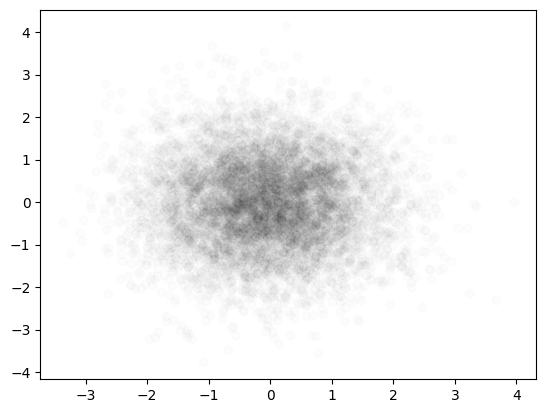

In [185]:
import matplotlib.pyplot as plt
example_VAE = VAE()
for batch in datagenerator:
    X, Y = batch
    z_mu, z_log_var, z, Xhat = example_VAE(X['seq'])
    
    plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy(), color='black', alpha=0.01)

In [186]:
len(seqs)

7865

In [187]:
example_vae.decoder

Decoder(
  (linear_1): Linear(in_features=3, out_features=200, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=1239, bias=True)
)

In [212]:
example_vae = VAE()

In [213]:
z_mu, z_log_var, z, Xhat = example_vae(X['seq'])

In [214]:
example_vae.elbo_loss(z_mu, z_log_var)

tensor(0.0007, grad_fn=<MulBackward0>)

In [215]:
z_log_var

tensor([[ 0.0400,  0.0007, -0.0539],
        [ 0.0465,  0.0098, -0.0303],
        [ 0.0503, -0.0010, -0.0392],
        [ 0.0268,  0.0022, -0.0121],
        [ 0.0591, -0.0037, -0.0282],
        [ 0.0457, -0.0355, -0.0289],
        [ 0.0396, -0.0096, -0.0092],
        [ 0.0213,  0.0209, -0.0365],
        [ 0.0471,  0.0175, -0.0433],
        [ 0.0391, -0.0036, -0.0367],
        [ 0.0516, -0.0144, -0.0396],
        [ 0.0594, -0.0177, -0.0453],
        [ 0.0394, -0.0074, -0.0317],
        [ 0.0408, -0.0020, -0.0354],
        [ 0.0481, -0.0044, -0.0309],
        [ 0.0279,  0.0124, -0.0384],
        [ 0.0166, -0.0119, -0.0162],
        [ 0.0368, -0.0048, -0.0277],
        [ 0.0626, -0.0048, -0.0463],
        [ 0.0610,  0.0128, -0.0519],
        [ 0.0165,  0.0111, -0.0258],
        [ 0.0346, -0.0084, -0.0595],
        [ 0.0548, -0.0242, -0.0502],
        [ 0.0343,  0.0013, -0.0183],
        [ 0.0511,  0.0255, -0.0394]], grad_fn=<AddmmBackward0>)

In [216]:
59*21

1239

In [217]:
test = X['seq'].reshape([X['seq'].shape[0],-1])

In [218]:
test.shape

torch.Size([25, 1239])

In [220]:
test.shape

torch.Size([25, 1239])

In [250]:
example_vae = VAE()

epochs = 100

recon_loss_tracker = []
elbo_loss_tracker = []
optim = torch.optim.Adam(example_vae.parameters(), lr = 1e-3)

for epoch in range(epochs):
    total_recon_loss = 0
    total_elbo_loss = 0
    for batch in datagenerator:
        optim.zero_grad()
        X, Y = batch
        test = X['seq'].reshape([X['seq'].shape[0],-1])
        z_mu, z_log_var, z, Xhat = example_vae(X['seq'])

        recon_loss = 1000*example_vae.recon_loss(Y['seq'], Xhat)
        elbo_loss = example_vae.elbo_loss(z_mu, z_log_var)
        total_loss = recon_loss + elbo_loss

        total_loss.backward()
        optim.step()
        total_recon_loss += recon_loss.item()
        total_elbo_loss += elbo_loss.item()
        
    recon_loss_tracker.append(total_recon_loss)
    print(total_recon_loss)
    print(total_elbo_loss)
    

33790.90406036377
106.3904462569626
30815.54483795166
385.5485910177231
28697.18212890625
546.7586294412613
27171.048263549805
631.8425092697144
26100.512580871582
667.8068192005157
25385.562496185303
691.6650992631912
24837.75405883789
707.0642284154892
24400.87917327881
718.3092572689056
24018.1534576416
730.6868337392807
23669.144939422607
739.3417282104492
23387.34157180786
747.296019911766
23162.985591888428
751.623973608017
22971.828315734863
753.9849143028259
22803.09884262085
760.858537197113
22649.484115600586
769.6815984249115
22465.244396209717
771.0675466060638
22285.801177978516
778.4644403457642
22126.299606323242
782.3374886512756
21977.81432723999
781.8576881885529
21828.662364959717
788.8953075408936
21733.512283325195
787.2061455249786
21652.732276916504
797.6994721889496
21525.99192428589
797.5996663570404
21427.649379730225
800.79443359375
21311.64910507202
804.6049003601074
21247.495429992676
809.6191875934601
21186.65431213379
816.0280833244324
21129.94171524048
8

KeyboardInterrupt: 

In [242]:
recon_loss

tensor(128.3549, grad_fn=<MulBackward0>)

In [263]:
z_mu, z_log_var, z, Xhat = example_vae(X['seq'])

In [267]:
torch.where(Xhat[0][1]==max(Xhat[0][1]))

(tensor([11]),)

In [265]:
np.round(Xhat[0][3].detach().numpy(),2)

array([0.02, 0.  , 0.01, 0.03, 0.01, 0.03, 0.  , 0.  , 0.  , 0.05, 0.  ,
       0.01, 0.  , 0.13, 0.64, 0.05, 0.  , 0.  , 0.  , 0.02, 0.  ],
      dtype=float32)

In [268]:
np.where(Y['seq'][0][1] == 1)

(array([11]),)

In [269]:
z_mu

tensor([[-0.4016,  0.4643,  0.5004],
        [ 0.3898,  4.1160, -0.6407],
        [ 1.5807,  0.2429,  2.3975],
        [ 1.3053, -2.5748, -2.7898],
        [-2.6145, -0.3947,  0.7382],
        [-1.8628, -1.3619, -0.1456],
        [-2.1516, -0.4739, -2.0030],
        [-0.8504,  0.4411, -2.4084],
        [ 0.1945, -0.4145, -3.1878],
        [-0.8973,  2.5606,  0.3547],
        [-2.7515,  1.6219, -0.4506],
        [-3.4285,  0.3150,  3.0471],
        [-0.3167,  2.8010, -1.2279],
        [ 3.5177,  1.7343,  0.5647],
        [ 2.5863, -2.1515,  1.1407],
        [ 1.0813, -0.1893, -1.9933],
        [ 1.6887,  1.6050, -1.7523],
        [ 2.8729,  0.4453,  3.0031],
        [ 0.0333, -0.0622,  0.7316],
        [ 2.4623, -0.1326, -1.4092],
        [ 1.5218, -1.0659, -1.0285],
        [-0.2300,  1.0365,  0.3738],
        [ 0.7927,  2.0813,  0.7999],
        [ 1.3476,  2.5889,  1.8108],
        [-0.1664, -1.2719,  0.1784]], grad_fn=<AddmmBackward0>)

In [262]:
Xhat[0][3]

tensor([0.0537, 0.0444, 0.0422, 0.0441, 0.0416, 0.0516, 0.0497, 0.0439, 0.0442,
        0.0420, 0.0445, 0.0479, 0.0509, 0.0486, 0.0432, 0.0488, 0.0535, 0.0463,
        0.0516, 0.0562, 0.0511], grad_fn=<SelectBackward0>)

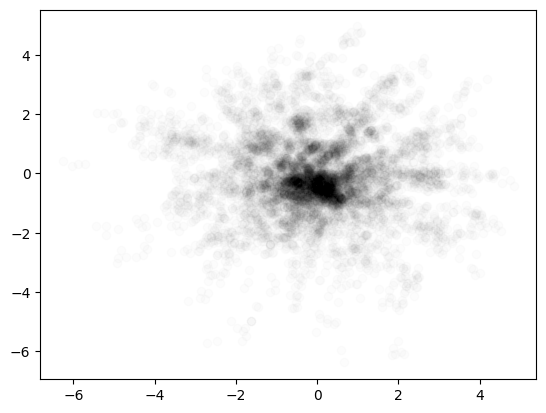

In [270]:

for batch in datagenerator:
    X, Y = batch
    z_mu, z_log_var, z, Xhat = example_vae(X['seq'])
    
    plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy(), color='black', alpha=0.01)

In [113]:
torch.where(Xhat[0][1] == max(Xhat[0][1]))

(tensor([14]),)

In [114]:
torch.where(Y['seq'][0][1]==1)

(tensor([2]),)

In [31]:
example_vae.recon_loss(Y['seq'], Xhat)

tensor([[[0.0573, 0.0425, 0.0448,  ..., 0.0478, 0.0359, 0.0486],
         [0.0433, 0.0507, 0.0479,  ..., 0.0561, 0.0435, 0.0452],
         [0.0450, 0.0420, 0.0470,  ..., 0.0576, 0.0489, 0.0408],
         ...,
         [0.0577, 0.0461, 0.0372,  ..., 0.0444, 0.0513, 0.0453],
         [0.0464, 0.0468, 0.0460,  ..., 0.0510, 0.0528, 0.0440],
         [0.0619, 0.0459, 0.0466,  ..., 0.0470, 0.0496, 0.0506]],

        [[0.0604, 0.0432, 0.0455,  ..., 0.0474, 0.0388, 0.0499],
         [0.0420, 0.0506, 0.0449,  ..., 0.0544, 0.0467, 0.0519],
         [0.0461, 0.0458, 0.0439,  ..., 0.0565, 0.0474, 0.0423],
         ...,
         [0.0553, 0.0468, 0.0415,  ..., 0.0475, 0.0463, 0.0486],
         [0.0522, 0.0483, 0.0475,  ..., 0.0494, 0.0500, 0.0430],
         [0.0627, 0.0444, 0.0438,  ..., 0.0421, 0.0498, 0.0486]],

        [[0.0554, 0.0423, 0.0440,  ..., 0.0481, 0.0351, 0.0487],
         [0.0432, 0.0507, 0.0485,  ..., 0.0566, 0.0427, 0.0433],
         [0.0446, 0.0418, 0.0473,  ..., 0.0574, 0.0485, 0.

tensor(-0.1920, grad_fn=<MeanBackward0>)

In [86]:
Xhat[0][2]

tensor([0.0559, 0.0564, 0.0475, 0.0458, 0.0423, 0.0439, 0.0462, 0.0527, 0.0450,
        0.0407, 0.0398, 0.0435, 0.0565, 0.0509, 0.0396, 0.0517, 0.0602, 0.0472,
        0.0412, 0.0491, 0.0440], grad_fn=<SelectBackward0>)

In [69]:
X['seq'].view(X['seq'].shape[0], 59*21).shape

torch.Size([25, 1239])

In [52]:
sh3_dataset[sh3_dataset['Type'] == 'Naturals']['Sequences']

0       VFLGVYKALYDYEPQTTEELAIREDELLYLLEKSDEWWTVKKDEPV...
1       PVINSVRALYDYDQNPDEELTFHENEEFDVYDDQDDWLLVQKTGAC...
2       KARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKDWWMCELSGQK...
3       TGSNKNKVLFAYSKQDADEVSISLRDLVALEAADGGWTKIKNTGET...
4       MPTRTMQAQYDYEAQGDDELSLTPNDVVNVIRGDDGWTYGE-NGEK...
                              ...                        
7860    AALFKVKALYDFEAKEDDDLGFPGGQVIDVTEEVDNWLEGTYSSKS...
7861    PKDPQFKALYDFVGQTGGELSLAKNQVIYITRKENGWWLGKQGSAS...
7862    RQSQVIKAVYDYNAPTNMCLSFSAGDFLHVVSREDEWYEACNRGER...
7863    PAGIYGVVSYDFHAERPDELDAKEGEAIIVIAQSNEWFVAKPLGGP...
7864    LDPDKLYALYAFNGHSSHCQLGQDEPCILLNDQDAYWWLVKRITDG...
Name: Sequences, Length: 7865, dtype: object

In [53]:
seqs = np.asarray([ list(seq) for seq in sh3_dataset[sh3_dataset['Type'] == 'Naturals']['Sequences']])

In [61]:
len(seqs[0])

59

In [54]:
dataset = ProteinDataset(seqs)

In [55]:
len(dataset)

7865

In [56]:
datagenerator = torch.utils.data.DataLoader(dataset, batch_size=32)

In [64]:
for batch in datagenerator:
    X, Y = batch
    print(X['seq'].shape[0])

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
25


In [63]:
X['seq'].shape

torch.Size([32, 59, 21])

"ABAC"

[
[1 0 0]
[0 1 0]
[1 0 0]
[0 0 1]
]


In [5]:
AMINO_ACIDS = "ARNDCQEGHILKMFPSTWYV-"
IDX_TO_AA = list(AMINO_ACIDS)

In [6]:
AMINO_ACIDS

'ARNDCQEGHILKMFPSTWYV-'

In [9]:
IDX_TO_AA[6]

'E'

In [13]:
AA_TO_IDX = {aa : i for i, aa in enumerate(IDX_TO_AA)}

In [15]:
AA_TO_IDX['A']

0

In [16]:
seq = sh3_dataset['Sequences'][0]

In [17]:
seq

'VFLGVYKALYDYEPQTTEELAIREDELLYLLEKSDEWWTVKKDEPVGLVPSNYVEQAPV'

In [21]:
def one_hot_encode(
    seq
):
    """
    generate one hot encoded sequences
    """
    seq_vector = torch.zeros((len(seq), len(IDX_TO_AA)), dtype=torch.float32)
    
    for index, char in enumerate(seq):
        seq_vector[index, AA_TO_IDX[char]] = 1.

    return seq_vector

In [23]:
one_hot_encoded_seq = one_hot_encode(seq)

In [28]:
one_hot_encoded_seq

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [26]:
IDX_TO_AA[19]

'V'

In [27]:
seq[0]

'V'